In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
from nanonets import NanoparticleElectrostatic
from nanonets.utils import display_network

plt.style.use(["science","bright","grid"])

In [12]:
def force_directed_packing(initial_positions: dict, radii_pos_keys: np.ndarray, radius_neg_keys: float = 10.0,
                           min_surface_dist: float = 1.0,max_iter: int = 1000, resolution_steps: int = 5,
                           k_repel: float = 1.0,k_attract: float = 0.01,step_size: float = 0.05,
                           convergence_threshold: float = 1e-3, planarity_safety_factor: float = 0.4) -> dict:
    """
    Arranges spheres using a force-directed layout with a guaranteed
    non-overlapping final state.

    This function adds a "hard push" collision resolution step after each
    force-based update to ensure the minimum distance constraint is always met.

    Attributes
    ----------
        initial_positions : dict
            Dict mapping sphere index {idx: np.array([x, y]), ...}. Can contain positive and negative integer keys.
        radii_pos_keys : np.ndarray
            NumPy array where radii_pos_keys[i] is the radius for sphere with positive key `i`.
        radius_neg_keys : float
            The single, constant radius for all spheres with negative keys.
        min_surface_dist : float
            The minimum required distance between surfaces.
        max_iter : int
            The maximum number of simulation steps.
        resolution_steps : int
            How many times to run the collision resolution step per main iteration. Important for stability.
        k_repel : float
            Spring constant for the repulsive force.
        k_attract : float
            Spring constant for the attractive force.
        step_size : float
            The base speed of the simulation. Determines the intended movement distance
            before planarity capping is applied. Recommended: 0.01-0.1.
        convergence_threshold : float
            The desired *average* movement per sphere to consider the system converged.
            The simulation stops if `total_movement < num_spheres * threshold`.
            Recommended: 1e-6 to 1e-8 for high precision.
        planarity_safety_factor : float
            Limits a sphere's movement to this fraction of the distance to its
            nearest neighbor. The key parameter for preserving planarity.
            Recommended: 0.3-0.5.
    
    Returns
    -------
        dict
            A dictionary with the final, updated positions for all spheres.
    """

    if not initial_positions:
        return {}
        
    positions = {idx: np.copy(pos) for idx, pos in initial_positions.items()}
    num_spheres = len(positions)
    sphere_indices = list(positions.keys())

    # The center of mass is the single point of attraction
    initial_center_of_mass = np.mean(np.array(list(positions.values())), axis=0)

    for i in range(max_iter):
        net_forces = {idx: np.zeros(2) for idx in sphere_indices}
        
        # --- 1. Calculate Repulsive and Attractive Forces ---
        for j in range(num_spheres):
            # Attractive Force
            idx_j = sphere_indices[j]
            vec_to_center = initial_center_of_mass - positions[idx_j]
            net_forces[idx_j] += k_attract * vec_to_center
            
            # Repulsive Forces
            for k in range(j + 1, num_spheres):
                idx1, idx2 = sphere_indices[j], sphere_indices[k]
                pos1, pos2 = positions[idx1], positions[idx2]
                radius1 = radii_pos_keys[idx1] if idx1 >= 0 else radius_neg_keys
                radius2 = radii_pos_keys[idx2] if idx2 >= 0 else radius_neg_keys
                
                vec = pos2 - pos1
                dist = np.linalg.norm(vec)
                target_dist = radius1 + radius2 + min_surface_dist
                
                if dist < target_dist and dist > 1e-9:
                    overlap = target_dist - dist
                    force_magnitude = k_repel * overlap
                    direction = vec / dist
                    force_vec = force_magnitude * direction
                    net_forces[idx1] -= force_vec
                    net_forces[idx2] += force_vec

        # --- 2. Dynamically Capped Position Update (for Planarity) ---
        total_relative_movement = 0.0
        
        # Recalculate distance matrix in each iteration as positions change
        pos_array = np.array([positions[i] for i in sphere_indices])
        dist_matrix = np.linalg.norm(pos_array[:, np.newaxis, :] - pos_array[np.newaxis, :, :], axis=2)
        
        for j, idx in enumerate(sphere_indices):
            force = net_forces[idx]
            
            # **FIXED LOGIC**: Use step_size to determine intended movement
            intended_movement_vector = step_size * force
            
            # Find distance to the nearest other sphere to use for the cap
            min_dist_to_neighbor = np.min(dist_matrix[j] + np.eye(num_spheres)[j] * 1e9)
            max_allowed_movement = planarity_safety_factor * min_dist_to_neighbor
            
            intended_dist = np.linalg.norm(intended_movement_vector)
            
            # If intended movement is too large, cap it to the allowed maximum
            if intended_dist > max_allowed_movement:
                movement_vector = intended_movement_vector * (max_allowed_movement / intended_dist)
            else:
                movement_vector = intended_movement_vector

            positions[idx] += movement_vector
            radius = radii_pos_keys[idx] if idx >0 else radius_neg_keys
            total_relative_movement += np.linalg.norm(movement_vector) / (radius + 1e-9)
            
        # --- 3. Hard Constraint Projection (for Non-Overlap Guarantee) ---
        for _ in range(resolution_steps):
            for j in range(num_spheres):
                for k in range(j + 1, num_spheres):
                    idx1, idx2 = sphere_indices[j], sphere_indices[k]
                    # ... [This code block is correct and remains unchanged] ...
                    pos1, pos2 = positions[idx1], positions[idx2]
                    radius1 = radii_pos_keys[idx1] if idx1 >= 0 else radius_neg_keys
                    radius2 = radii_pos_keys[idx2] if idx2 >= 0 else radius_neg_keys
                    vec = pos2 - pos1
                    dist = np.linalg.norm(vec)
                    target_dist = radius1 + radius2 + min_surface_dist
                    if dist < target_dist and dist > 1e-9:
                        overlap = target_dist - dist
                        direction = vec / dist
                        positions[idx1] -= direction * (overlap / 2)
                        positions[idx2] += direction * (overlap / 2)

        avg_relative_movement = total_relative_movement / num_spheres
        # --- 4. Check for Convergence ---
        # Using the robust relative threshold
        if i > 10 and avg_relative_movement < convergence_threshold:
            print(f"Converged after {i+1} iterations.")
            break
    else:
        print(f"Reached max iterations ({max_iter}).")
        
    return positions


In [67]:
# Lattice
N_x, N_y        = 9,9
electrode_pos   = [[(N_x-1)//2, 0],[0, 0],[N_x-1, 0],[0, (N_y-1)//2],
                       [N_x-1, (N_y-1)//2],[0, N_y-1],[N_x-1, N_y-1],[(N_x-1)//2, N_y-1]]

# Two NP Types
r_mean_1, r_std_1   = 10.0, 0.0
r_mean_2, r_std_2   = 20.0, 0.0
N_particles         = N_x * N_y
pos, topo, rad, Gs  = {}, {}, {}, {}
dist, e_dist        = {}, {}

for i in range(10):
    rng = np.random.RandomState(seed=i)
    np_index_type_2 = rng.choice(np.arange(N_particles),N_particles//3, replace=False)

    lattice_net = NanoparticleElectrostatic(seed=i)

    # Build Network and attach Electrodes
    lattice_net.lattice_network(N_x, N_y)
    lattice_net.add_electrodes_to_lattice_net(electrode_pos)
    lattice_net.add_np_to_output()
    lattice_net.init_nanoparticle_radius(mean_radius=r_mean_1, std_radius=r_std_1)
    lattice_net.update_nanoparticle_radius(np_index_type_2, mean_radius=r_mean_2, std_radius=r_std_2)
    lattice_net.pack_planar_circles()

    G_lat           = lattice_net.get_graph()
    pos_lat         = lattice_net.get_positions()
    rad_lat         = lattice_net.get_radius()
    net_topo_lat    = lattice_net.get_net_topology()
    d               = lattice_net.get_dist_matrix()
    e_d             = lattice_net.get_electrode_dist_matrix()
    pos_lat         = force_directed_packing(pos_lat, rad_lat, k_attract=0.1, convergence_threshold=1e-3, step_size=0.02)
    
    pos[i]      = pos_lat
    topo[i]     = net_topo_lat
    rad[i]      = rad_lat
    Gs[i]       = G_lat
    dist[i]     = d
    e_dist[i]   = e_d

Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).
Reached max iterations (1000).


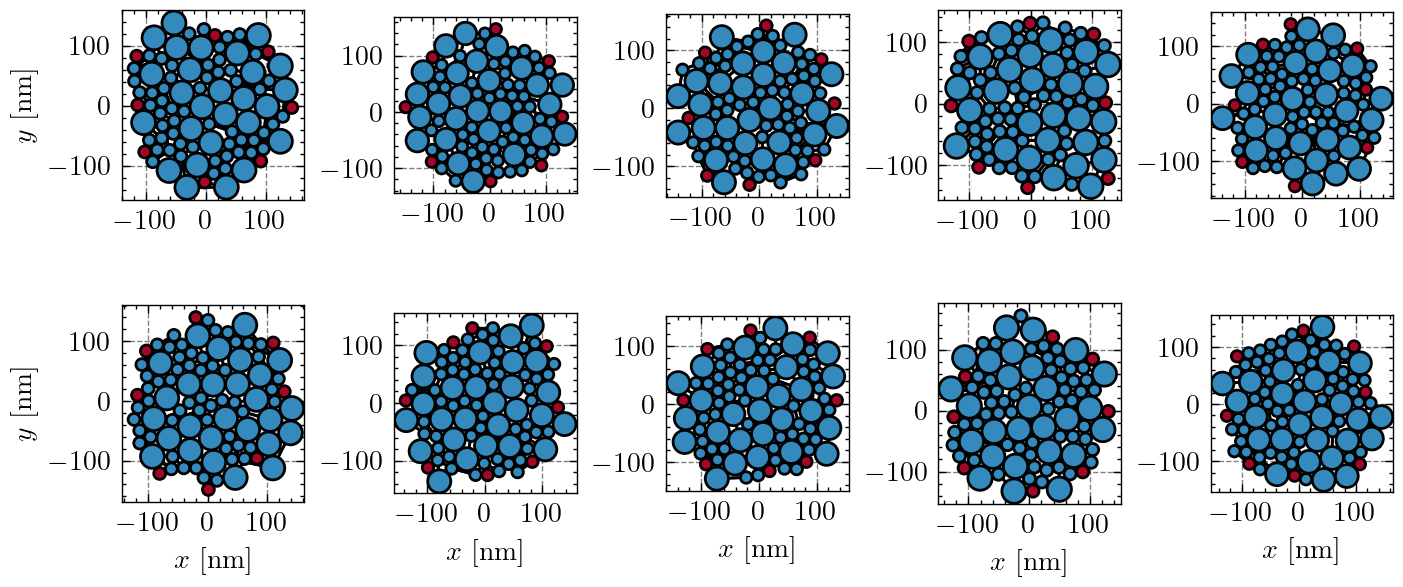

In [73]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*1.2)
for i in range(10):
    ax      = fig.add_subplot(2,5,i+1)
    fig,ax  = display_network(Gs[i], pos[i], rad[i], topo[i], fig=fig, ax=ax)
    if i >= 5:
        _ = ax.set_xlabel("$x$ [nm]")
    if i % 5 == 0:
        _ = ax.set_ylabel("$y$ [nm]")

In [76]:
np.save("data/radius_dis.npy", np.array([rad[i] for i in range(10)]))
np.save("data/topo_dis.npy", np.array([topo[i] for i in range(10)]))
np.save("data/dist_dis.npy", np.array([dist[i] for i in range(10)]))
np.save("data/e_dist_dis.npy", np.array([e_dist[i] for i in range(10)]))
for i in range(10):
    pd.DataFrame(pos[i]).T.to_csv(f"data/pos/pos_{i}.csv")
# np.save("data/topo_dis.npy", np.array([topo[i] for i in range(10)]))

In [70]:
np.load("data/radius_dis.npy")[0]

array([10., 10., 20., 20., 20., 10., 10., 20., 10., 10., 10., 10., 10.,
       20., 10., 10., 10., 10., 10., 10., 10., 10., 20., 10., 10., 10.,
       20., 20., 10., 10., 20., 10., 10., 20., 10., 10., 10., 10., 10.,
       10., 20., 20., 20., 20., 10., 10., 10., 10., 20., 10., 20., 10.,
       10., 20., 10., 20., 10., 20., 10., 10., 10., 20., 10., 10., 10.,
       10., 20., 10., 10., 20., 10., 20., 10., 20., 20., 10., 20., 10.,
       10., 10., 20., 10.])

In [71]:
np.load("data/topo_dis.npy")[0]

array([[   2,    1,    9, -100, -100, -100],
       [-100,    0,    2,   10, -100, -100],
       [-100,    1,    3,   11, -100, -100],
       [-100,    2,    4,   12, -100, -100],
       [   1,    3,    5,   13, -100, -100],
       [-100,    4,    6,   14, -100, -100],
       [-100,    5,    7,   15, -100, -100],
       [-100,    6,    8,   16, -100, -100],
       [   3,    7,   17, -100, -100, -100],
       [-100,    0,   10,   18, -100, -100],
       [-100,    1,    9,   11,   19, -100],
       [-100,    2,   10,   12,   20, -100],
       [-100,    3,   11,   13,   21, -100],
       [-100,    4,   12,   14,   22, -100],
       [-100,    5,   13,   15,   23, -100],
       [-100,    6,   14,   16,   24, -100],
       [-100,    7,   15,   17,   25, -100],
       [-100,    8,   16,   26, -100, -100],
       [-100,    9,   19,   27, -100, -100],
       [-100,   10,   18,   20,   28, -100],
       [-100,   11,   19,   21,   29, -100],
       [-100,   12,   20,   22,   30, -100],
       [-1

In [83]:
e_d.shape[0]

8

In [72]:
df = pd.read_csv("data/pos/pos_0.csv", index_col=0)
dict(zip(df.index, df.to_numpy()))

{0: array([-94.09612536, -57.73042967]),
 1: array([-88.53115097, -93.55267002]),
 2: array([ -61.30164796, -108.27619419]),
 3: array([ -31.50795777, -136.43344229]),
 4: array([  34.21887504, -135.98118662]),
 5: array([  13.36849822, -113.07910585]),
 6: array([  32.7405112 , -105.07959227]),
 7: array([  63.66744201, -107.47943197]),
 8: array([ 95.87122825, -71.95959979]),
 9: array([-80.97342753, -73.98575617]),
 10: array([-60.06008177, -74.52373505]),
 11: array([-42.19535497, -63.65568132]),
 12: array([-41.58547454, -84.46145004]),
 13: array([-14.38103559, -99.22422119]),
 14: array([ 15.75445363, -92.34493016]),
 15: array([ 35.03568862, -84.30867541]),
 16: array([ 55.01878659, -77.78672156]),
 17: array([ 75.91539053, -78.5468676 ]),
 18: array([-73.47674887, -54.43357896]),
 19: array([-71.99180043, -33.4468329 ]),
 20: array([-54.19536279, -46.38716567]),
 21: array([-21.51507614, -69.11399775]),
 22: array([  8.71748159, -62.26057626]),
 23: array([ 39.43983157, -63.92